▶ 1m 격자 라디오맵 저장 완료: radiomap_1m_interpolated.csv


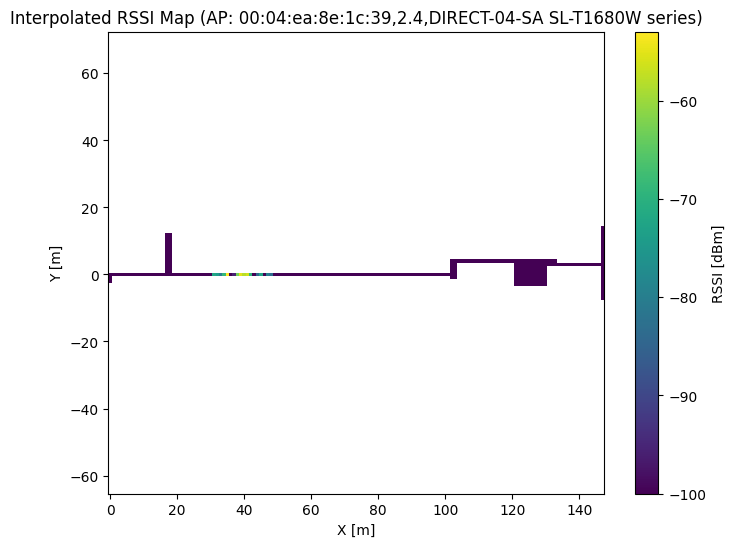

In [ ]:
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

class RadiomapInterpolator:
    """
    원본 라디오맵 데이터를
      1) xr, yr 단위 1m 격자로 반올림→정수화
      2) 각 xr 열의 y_min→y_max 구간 채움
      3) xr들 사이에 gap이 있으면, 인접 두 열 y 범위의 합집합으로 채움
      4) cubic 보간 → NaN을 -100으로, -100 이하 클램핑
      5) CSV 저장 및 시각화
    """

    def __init__(self, input_csv: str, output_csv: str):
        """
        :param input_csv: 원본 CSV 경로 (필수 칼럼: x,y + 여러 AP RSSI)
        :param output_csv: 1m 격자 결과를 저장할 CSV 경로
        """
        self.input_csv = input_csv
        self.output_csv = output_csv

    def load_and_round(self) -> pd.DataFrame:
        """
        1) CSV 로드
        2) x,y 좌표에 대해 1m 격자(round→int) 컬럼(xr,yr) 추가
        """
        df = pd.read_csv(self.input_csv)
        df['xr'] = df['x'].round().astype(int)  # x→xr
        df['yr'] = df['y'].round().astype(int)  # y→yr
        return df

    def build_grid_points(self, df: pd.DataFrame) -> np.ndarray:
        """
        원래 로직대로,
          - 각 고유 xr마다 y_min→y_max 채움
          - xr들 사이에 gap이 있으면 인접 열 y 범위 합집합으로 채움
        최종 (N,2) 배열을 반환.
        """
        unique_x = np.sort(df['xr'].unique())
        # 미리 각 xr에 대한 y_min, y_max 계산
        y_ranges = {
            xr: (int(group.yr.min()), int(group.yr.max()))
            for xr, group in df.groupby('xr')
        }

        rows = []
        for idx, xr in enumerate(unique_x):
            y_min, y_max = y_ranges[xr]
            # (1) 현재 xr 열의 y 구간 채우기
            for yr in range(y_min, y_max + 1):
                rows.append((xr, yr))

            # (2) 다음 xr과 gap이 있으면, gap 열마다 인접 두 열 y 범위의 합집합으로 채우기
            if idx + 1 < len(unique_x):
                next_x = unique_x[idx + 1]
                if next_x - xr > 1:
                    y_min2, y_max2 = y_ranges[next_x]
                    fill_y_min = min(y_min, y_min2)
                    fill_y_max = max(y_max, y_max2)
                    # gap 내 모든 xr 열
                    for fill_x in range(xr + 1, next_x):
                        for yr in range(fill_y_min, fill_y_max + 1):
                            rows.append((fill_x, yr))

        # 튜플 리스트 → numpy array
        return np.array(rows, dtype=int)

    def interpolate(self, df: pd.DataFrame, points: np.ndarray) -> pd.DataFrame:
        """
        1) df에서 (xr,yr) 포인트 + RSSI 컬럼 추출
        2) cubic 보간, NaN→-100, -100 이하 클램핑
        3) 결과 DataFrame 반환
        """
        # RSSI 칼럼만 선택
        rssi_cols = [c for c in df.columns if c not in ('x','y','xr','yr')]
        grid_data = {
            'x': points[:, 0],
            'y': points[:, 1]
        }
        sample_pts = df[['xr','yr']].values

        for col in rssi_cols:
            # cubic 보간 + fill_value
            interp_vals = griddata(
                sample_pts,
                df[col].values,
                points,
                method='cubic',
                fill_value=-100
            )
            # -100 이하 모두 -100으로
            grid_data[col] = np.clip(interp_vals, -100, None)

        return pd.DataFrame(grid_data)

    def save_and_visualize(self, grid_df: pd.DataFrame, ap_index: int = 0):
        """
        1) CSV 저장
        2) 첫 번째(또는 지정한) AP RSSI를 2D 컬러맵으로 시각화
        """
        grid_df.to_csv(self.output_csv, index=False)
        print(f"▶ 1m 격자 라디오맵 저장 완료: {self.output_csv}")

        # 시각화: 'x','y' 뒤에 AP 컬럼이 이어짐
        ap_col = grid_df.columns[2 + ap_index]
        pivot = grid_df.pivot(index='y', columns='x', values=ap_col)

        plt.figure(figsize=(8,6))
        plt.pcolormesh(
            pivot.columns, pivot.index, pivot.values,
            shading='auto', cmap='viridis'
        )
        plt.title(f"Interpolated RSSI Map (AP: {ap_col})")
        plt.xlabel('X [m]')
        plt.ylabel('Y [m]')
        plt.colorbar(label='RSSI [dBm]')
        plt.axis('equal')
        plt.show()

    def run(self):
        """
        전체 실행 순서:
         1) 로드 및 반올림
         2) 그리드 포인트 생성
         3) 보간
         4) 저장 + 시각화
        """
        df = self.load_and_round()
        points = self.build_grid_points(df)
        grid_df = self.interpolate(df, points)
        self.save_and_visualize(grid_df)


if __name__ == "__main__":
    interpolator = RadiomapInterpolator(
        input_csv='test101_20250507_211636_Radiomap.csv',
        output_csv='radiomap_1m_interpolated.csv'
    )
    interpolator.run()
